## Imports

In [12]:
import numpy as np
import gzip
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.sparse import coo_matrix


## Slides

In [13]:
def getGRCIndex(x, y, xbl, ybl):
    j = 0
    for b in xbl[1:]:
        if x < b:
            break
        j += 1
    i = 0
    for b in ybl[1:]:
        if y < b:
            break
        i += 1
    return i, j

In [14]:
with gzip.open('../data/chips/NCSU-DigIC-GraphData-2023-07-25/counter/1/counter.json.gz', 'rb') as f:
    design = json.loads(f.read().decode('utf-8'))
print(design['nets'][3])
print(design['instances'][6])

{'name': 'zero', 'id': 3}
{'name': 'U22', 'id': 6, 'xloc': 6784, 'yloc': 7680, 'cell': 7, 'orient': 6}


In [15]:
with gzip.open('../data/chips/NCSU-DigIC-GraphData-2023-07-25/cells.json.gz', 'rb') as f:
    cells = json.loads(f.read().decode('utf-8'))
print(cells[7])

{'name': 'AOI21_X1', 'width': 768, 'height': 1536, 'terms': [{'name': 'A1', 'id': 1, 'dir': 0}, {'name': 'A2', 'id': 2, 'dir': 0}, {'name': 'B', 'id': 3, 'dir': 0}, {'name': 'ZN', 'id': 4, 'dir': 1}], 'id': 7}


In [16]:
data = np.load('../data/chips/NCSU-DigIC-GraphData-2023-07-25/counter/1/counter_congestion.npz')
lyr = list(data['layerList']).index('M1')
ybl = data['yBoundaryList']
xbl = data['xBoundaryList']
xloc = 0
yloc = 0
i, j = getGRCIndex(xloc, yloc, xbl, ybl)
print(data['demand'][lyr][i][j])
print(data['capacity'][lyr][i][j])

0
15


## My EDA

### Loading Data (XBAR 1 Only)

In [17]:
with gzip.open('../data/chips/NCSU-DigIC-GraphData-2023-07-25/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))

In [18]:
instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

In [19]:
instances

name    id   xloc   yloc  cell  orient
0       clk_gate_out_reg/latch     0  41984  44544    23       0
1     clk_gate_out_reg_0/latch     1  41984  47616    23       6
2     clk_gate_out_reg_1/latch     2  44160  44544    23       0
3     clk_gate_out_reg_2/latch     3  44160  47616    23       0
4     clk_gate_out_reg_3/latch     4  46336  47616    23       0
...                        ...   ...    ...    ...   ...     ...
3947                     U4123  3947  21888  53760    42       4
3948                     U4125  3948  33664  66048    42       0
3949                     U4128  3949  23296  66048    34       0
3950           ZCTSBUF_205_132  3950  40576  44544    11       0
3951           ZCTSBUF_466_133  3951  46848  44544    11       6

[3952 rows x 6 columns]

In [20]:
nets

name    id
0           clk     0
1         reset     1
2       in[383]     2
3       in[382]     3
4       in[381]     4
...         ...   ...
4477      n6899  4477
4478      n6900  4478
4479      n6903  4479
4480      n6915  4480
4481  ZCTSNET_2  4481

[4482 rows x 2 columns]

In [21]:
with gzip.open('../data/chips/NCSU-DigIC-GraphData-2023-07-25/cells.json.gz','rb') as f:
    cells = json.loads(f.read().decode('utf-8'))
cells

[{'name': 'AND2_X1',
  'width': 768,
  'height': 1536,
  'terms': [{'name': 'A1', 'id': 1, 'dir': 0},
   {'name': 'A2', 'id': 2, 'dir': 0},
   {'name': 'Z', 'id': 3, 'dir': 1}],
  'id': 0},
 {'name': 'AND2_X2',
  'width': 896,
  'height': 1536,
  'terms': [{'name': 'A1', 'id': 1, 'dir': 0},
   {'name': 'A2', 'id': 2, 'dir': 0},
   {'name': 'Z', 'id': 3, 'dir': 1}],
  'id': 1},
 {'name': 'AND3_X1',
  'width': 1024,
  'height': 1536,
  'terms': [{'name': 'A1', 'id': 1, 'dir': 0},
   {'name': 'A2', 'id': 2, 'dir': 0},
   {'name': 'A3', 'id': 3, 'dir': 0},
   {'name': 'Z', 'id': 4, 'dir': 1}],
  'id': 2},
 {'name': 'AND3_X2',
  'width': 1024,
  'height': 1536,
  'terms': [{'name': 'A1', 'id': 1, 'dir': 0},
   {'name': 'A2', 'id': 2, 'dir': 0},
   {'name': 'A3', 'id': 3, 'dir': 0},
   {'name': 'Z', 'id': 4, 'dir': 1}],
  'id': 3},
 {'name': 'AND4_X1',
  'width': 1152,
  'height': 1536,
  'terms': [{'name': 'A1', 'id': 1, 'dir': 0},
   {'name': 'A2', 'id': 2, 'dir': 0},
   {'name': 'A3', 'id

### Creating Graph (NetworkX)

In [22]:
# FROM SLIDES
conn=np.load('../data/chips/NCSU-DigIC-GraphData-2023-07-25/xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A

<3952x4482 sparse matrix of type '<class 'numpy.int64'>'
	with 17444 stored elements in COOrdinate format>

In [23]:
A = A.__mul__(A.T)
A

<3952x3952 sparse matrix of type '<class 'numpy.int64'>'
	with 141472 stored elements in Compressed Sparse Row format>

In [24]:
G = nx.from_numpy_array(A)

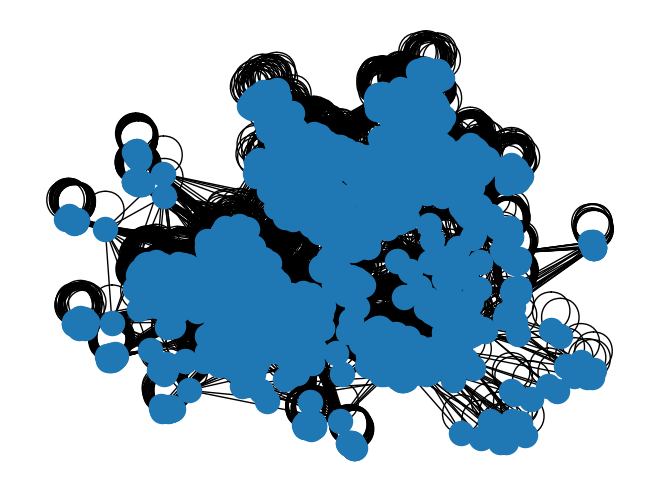

In [25]:
nx.draw(G)

In [26]:
seed = 13648
pos = nx.spring_layout(G, seed=seed, k=.2, iterations=20)

plt.figure(figsize=(30, 30))
node_sizes = [i/50 for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo", alpha=0.5)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
    alpha=0.2,
    arrows=True
)

plt.show()

### Distribution Analysis

Text(0.5, 1.0, 'Degree Distribution')

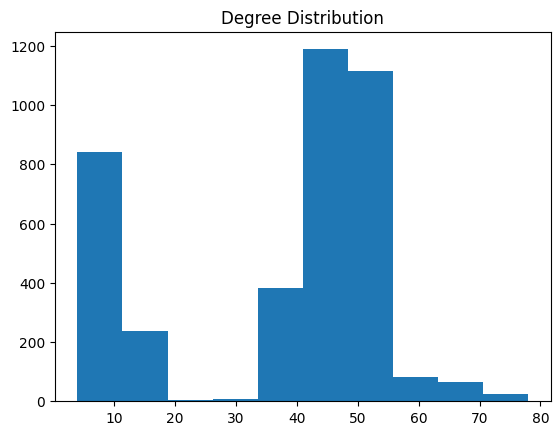

In [27]:
plt.hist(dict(G.degree()).values())
plt.title('Degree Distribution')

In [28]:
max_degree = max(dict(G.degree()).values())
min_degree = min(dict(G.degree()).values())

highest_degree_instance = -1
lowest_degree_instance = -1
for key, value in (G.degree()):
    if value == max_degree:
        highest_degree_instance = key
    if value == min_degree:
        lowest_degree_instance = key

print('max degree:', max_degree)
print(instances[instances['id'] == highest_degree_instance])
print()
print('min degree:', min_degree)
print(instances[instances['id'] == lowest_degree_instance])

max degree: 78
       name    id   xloc   yloc  cell  orient
3949  U4128  3949  23296  66048    34       0

min degree: 4
      name   id   xloc   yloc  cell  orient
488  U3705  488  19584  66048    34       6


cell
9     1152
56    1152
65     396
46     396
50     396
34     254
42      84
0       48
48      35
52      24
23      12
11       2
49       1
Name: count, dtype: int64


Text(0.5, 1.0, 'Cell Type Count Distribution')

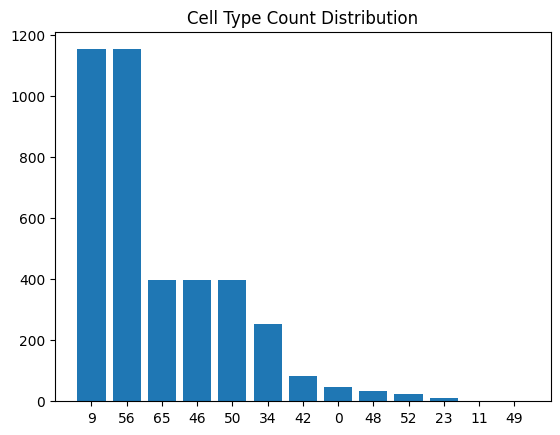

In [29]:
print(instances['cell'].value_counts())
plt.bar(x=instances['cell'].value_counts().index.astype(str), height= instances['cell'].value_counts().values)
plt.title('Cell Type Count Distribution')

In [30]:
print(instances['xloc'].mean())
print(instances['yloc'].mean())

42760.38866396761
44582.08906882591


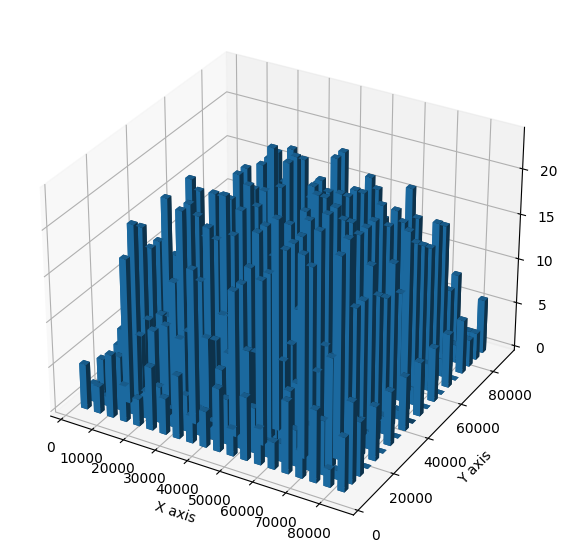

In [31]:
# Define bin edges
bins = 20

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(instances['xloc'], instances['yloc'], bins=bins)

# Generate the centers of the bins
xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])
xpos = xpos.flatten() / 2
ypos = ypos.flatten() / 2
zpos = np.zeros_like(xpos)

# Get the height of each bar
dz = hist.flatten()

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Set the size of each bar in the histogram
dx = dy = (xedges[1] - xedges[0]) / 2  # width and depth of the bars

# Create 3D bars
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Frequency')

plt.show()

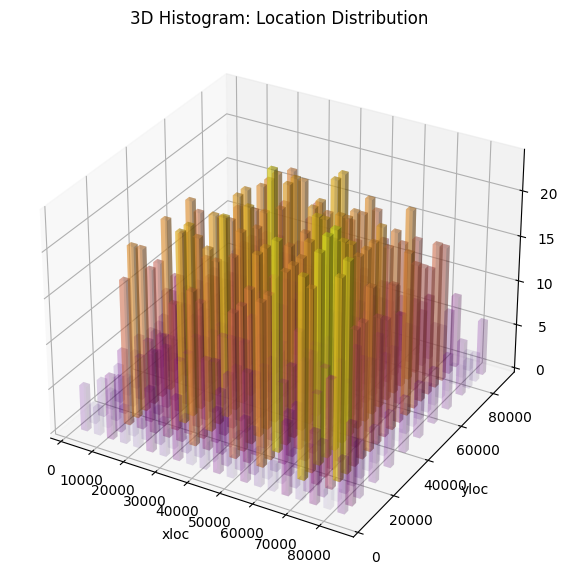

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

# Sample data: replace with your x and y coordinate arrays
x = instances['xloc']
y = instances['yloc']

# Define bin edges
bins = 20

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=bins)

# Generate the centers of the bins
xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])
xpos = xpos.flatten() / 2
ypos = ypos.flatten() / 2
zpos = np.zeros_like(xpos)

# Get the height of each bar
dz = hist.flatten()

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Set the size of each bar in the histogram
dx = dy = (xedges[1] - xedges[0]) / 2  # width and depth of the bars

# Normalize the heights to scale color and alpha values
norm = Normalize(vmin=min(dz), vmax=max(dz))
colors = cm.plasma(norm(dz))  # Choose a color map (e.g., viridis)

# Adjust alpha based on bar height (dz)
alphas = norm(dz)/2 # Scales between 0 and 1 based on height
colors[:, -1] = alphas  # Set the alpha channel to the scaled values

# Plot bars with variable color and transparency
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average')

# Set labels
ax.set_xlabel('xloc')
ax.set_ylabel('yloc')
ax.set_zlabel('Frequency')

plt.title('3D Histogram: Location Distribution')
plt.show()


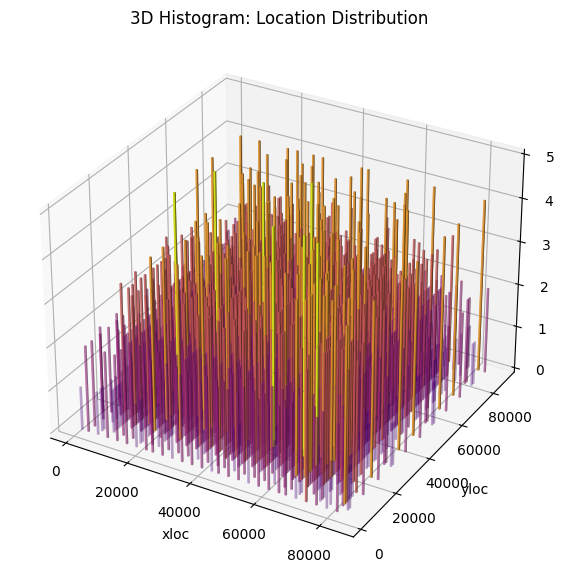

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

# Sample data: replace with your x and y coordinate arrays
x = instances['xloc']
y = instances['yloc']

# Define bin edges
bins = 80

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=bins)

# Generate the centers of the bins
xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])
xpos = xpos.flatten() / 2
ypos = ypos.flatten() / 2
zpos = np.zeros_like(xpos)

# Get the height of each bar
dz = hist.flatten()

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Set the size of each bar in the histogram
dx = dy = (xedges[1] - xedges[0]) / 2  # width and depth of the bars

# Normalize the heights to scale color and alpha values
norm = Normalize(vmin=min(dz), vmax=max(dz))
colors = cm.plasma(norm(dz))  # Choose a color map (e.g., viridis)

# Adjust alpha based on bar height (dz)
alphas = norm(dz) # Scales between 0 and 1 based on height
colors[:, -1] = alphas  # Set the alpha channel to the scaled values

# Plot bars with variable color and transparency
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average')

# Set labels
ax.set_xlabel('xloc')
ax.set_ylabel('yloc')
ax.set_zlabel('Frequency')

plt.title('3D Histogram: Location Distribution')
plt.show()
